In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
!ls

data  drive  outputs  sample_data


In [15]:
!pwd

/content


In [16]:
# need to change your data.zip dir
!unzip -q /content/drive/MyDrive/VisualPollution/data.zip -d '/content/'

replace /content/data/Bad Billboard/-3-e1416048067604.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [17]:
import os
output_dir = "./outputs"
if not os.path.exists(output_dir):
  os.mkdir(output_dir)

In [18]:
# import necessary libraries
import torch
import torchvision
from collections import Counter
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from torch.utils.data.sampler import WeightedRandomSampler
from torch.utils.data import random_split, DataLoader, Dataset
import torch.nn as nn
from tqdm import tqdm
from torchvision import transforms as T
import cv2


In [19]:
# create Early stopping Callback class

class EarlyStopping:
  """
  1. update the best training loss in every epoch.
  2. if the training loss will not less than best loss, then stop training and save best loss model.
  """
  def __init__(self, patience=5, delta=0, path='./outputs/checkpoint.pt'):
    self.patience = patience
    self.delta = delta
    self.path= path
    self.counter = 0
    self.best_score = None
    self.early_stop = False

  def __call__(self, val_loss, model):
    if self.best_score is None:
      self.best_score = val_loss
      self.save_checkpoint(model)
    elif val_loss > self.best_score:
      self.counter +=1
      if self.counter >= self.patience:
        self.early_stop = True 
    else:
      self.best_score = val_loss
      self.save_checkpoint(model)
      self.counter = 0      

  def save_checkpoint(self, model):
    torch.save(model.state_dict(), self.path)

In [20]:
# build classifier class 
class PollutionClassifier():
    def __init__(self, data_dir, num_classes, device, Transform=None, sample=False, loss_weights=False, batch_size=8,
     lr=1e-4, stop_early=True, freeze_backbone=True):
        self.data_dir = data_dir
        self.num_classes = num_classes
        self.device = device
        self.sample = sample
        self.loss_weights = loss_weights
        self.batch_size = batch_size
        self.lr = lr
        self.stop_early = stop_early
        self.freeze_backbone = freeze_backbone
        self.Transform = Transform


        self.logs = {}

    def load_data(self):
        """
        - create dataset from data folder
        - training and testing split to dataset
        - find class weights to fix imbalanced training data
        - create dataloader for training and testing using class weights
        - return trainloader and testloader
        """
        train_full = torchvision.datasets.ImageFolder(self.data_dir, transform=self.Transform)
        train_set, val_set = random_split(train_full, [math.floor(len(train_full)*0.8), math.ceil(len(train_full)*0.2)])

        self.train_classes = [label for _, label in train_set]
        if self.sample:
            # Need to get weight for every image in the dataset
            class_count = Counter(self.train_classes)
            class_weights = torch.Tensor([len(self.train_classes)/c for c in pd.Series(class_count).sort_index().values]) 

            sample_weights = [0] * len(train_set)
            for idx, (image, label) in enumerate(train_set):
                class_weight = class_weights[label]
                sample_weights[idx] = class_weight

            sampler = WeightedRandomSampler(weights=sample_weights,
                                            num_samples = len(train_set), replacement=True)  
            train_loader = DataLoader(train_set, batch_size=self.batch_size, sampler=sampler)
        else:
            train_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)

        val_loader = DataLoader(val_set, batch_size=self.batch_size)

        return train_loader, val_loader

    def load_model(self, arch='efficient-net'):
        """
        - load efficientnet_b0 model with pretrained weights from torchvision lib
        - freeze backbone and change model head
        - create optimizer and loss function
        """
        if arch == 'efficient-net':
            print(self.device)
            self.model = torchvision.models.efficientnet_b0(pretrained=True)
            if self.freeze_backbone:
                for param in self.model.parameters():
                    param.requires_grad = False
            
            # self.model._fc = nn.Linear(in_features=self.model._fc.in_features, out_features=self.num_classes)
            in_features = self.model.classifier[1].in_features
            self.model.classifier[1] = nn.Linear(in_features=in_features, out_features=self.num_classes)
            
        # print(self.model)
        self.model = self.model.to(self.device)

        self.optimizer = torch.optim.Adam(self.model.parameters(), self.lr) 

        if self.loss_weights:
            class_count = Counter(self.train_classes)
            class_weights = torch.Tensor([len(self.train_classes)/c for c in pd.Series(class_count).sort_index().values])
            class_weights = class_weights.to(self.device)  
            self.criterion = nn.CrossEntropyLoss(class_weights)
        else:
            self.criterion = nn.CrossEntropyLoss() 

    
    def fit_one_epoch(self, train_loader, epoch, num_epochs): 
        """
        - train model for one epoch
        - return loss and acc of epoch
        """
        step_train = 0

        train_losses = list() # Every epoch check average loss per batch 
        train_accs = list()
        self.model.train()
        for i, (images, targets) in enumerate(tqdm(train_loader)):
            images = images.to(self.device)
            targets = targets.to(self.device)

            logits = self.model(images)
            loss = self.criterion(logits, targets)

            loss.backward()
            self.optimizer.step()

            self.optimizer.zero_grad()

            train_losses.append(loss.item())

            #Calculate running train accuracy
            predictions = torch.argmax(logits, dim=1)
            num_correct = sum(predictions.eq(targets))
            running_train_acc = float(num_correct) / float(images.shape[0])
            train_accs.append(running_train_acc)
            
        train_loss = torch.tensor(train_losses).mean() 
        train_acc = torch.tensor(train_accs).mean() * 100  
        print(f'Epoch {epoch}/{num_epochs-1}')  
        print(f'Training loss: {train_loss:.2f}')
        print(f'Training accuracy: {train_acc:.2f}')

        return train_loss, train_acc

    def val_one_epoch(self, val_loader):
        """
        - valid model for one epoch
        - return loss and acc of epoch
        """
        val_losses = list()
        val_accs = list()
        self.model.eval()
        step_val = 0
        with torch.no_grad():
            for (images, targets) in val_loader:
                images = images.to(self.device)
                targets = targets.to(self.device)

                logits = self.model(images)
                loss = self.criterion(logits, targets)
                val_losses.append(loss.item())      
            
                predictions = torch.argmax(logits, dim=1)
                num_correct = sum(predictions.eq(targets))
                running_val_acc = float(num_correct) / float(images.shape[0])

                val_accs.append(running_val_acc)
            

            self.val_loss = torch.tensor(val_losses).mean()
            val_acc = torch.tensor(val_accs).mean() * 100 # Average acc per batch
        
            print(f'Validation loss: {self.val_loss:.2f}')  
            print(f'Validation accuracy: {val_acc:.2f}') 

        return self.val_loss, val_acc

    @staticmethod
    def save_plots(train_acc, valid_acc, train_loss, valid_loss):
        """
        Function to save the loss and accuracy plots to disk.
        """
        # accuracy plots
        plt.figure(figsize=(10, 7))
        plt.plot(
            train_acc, color='green', linestyle='-', 
            label='train accuracy'
        )
        plt.plot(
            valid_acc, color='blue', linestyle='-', 
            label='validataion accuracy'
        )
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.savefig(f"./outputs/accuracy.png")
        
        # loss plots
        plt.figure(figsize=(10, 7))
        plt.plot(
            train_loss, color='orange', linestyle='-', 
            label='train loss'
        )
        plt.plot(
            valid_loss, color='red', linestyle='-', 
            label='validataion loss'
        )
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(f"./outputs/loss.png")

    # training 
    def fit(self, train_loader, val_loader, num_epochs=10, unfreeze_after=5, checkpoint_dir='./outputs/checkpoint.pt'):
        if self.stop_early:
            early_stopping = EarlyStopping(
            patience=5, 
            path=checkpoint_dir)

        train_loss, valid_loss = [], []
        train_acc, valid_acc = [], []
        epoch_list = []

        for epoch in range(num_epochs):
            if self.freeze_backbone:
                if epoch == unfreeze_after:  # Unfreeze after x epochs
                    for param in self.model.parameters():
                        param.requires_grad = True
            train_loss_, train_acc_ = self.fit_one_epoch(train_loader, epoch, num_epochs)
            val_loss_, val_acc_ = self.val_one_epoch(val_loader)

            epoch_list.append(epoch)
            train_loss.append(train_loss_.numpy())
            valid_loss.append(val_loss_.numpy())
            train_acc.append(train_acc_.numpy())
            valid_acc.append(val_acc_.numpy())

            self.logs["epoch"] = epoch_list
            self.logs["train_loss"] = train_loss
            self.logs["valid_loss"] = valid_loss
            self.logs["train_acc"] = train_acc
            self.logs["valid_acc"] = valid_acc

            if self.stop_early:
                early_stopping(self.val_loss, self.model)
                if early_stopping.early_stop:
                    print('Early Stopping')
                    print(f'Best validation loss: {early_stopping.best_score}')
                    break
        
        self.save_plots(train_acc, valid_acc, train_loss, valid_loss)

cuda


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

100%|██████████| 101/101 [00:15<00:00,  6.46it/s]


Epoch 0/19
Training loss: 2.29
Training accuracy: 24.75
Validation loss: 2.20
Validation accuracy: 35.58


100%|██████████| 101/101 [00:08<00:00, 12.00it/s]


Epoch 1/19
Training loss: 2.14
Training accuracy: 37.87
Validation loss: 2.07
Validation accuracy: 50.96


100%|██████████| 101/101 [00:08<00:00, 12.01it/s]


Epoch 2/19
Training loss: 2.05
Training accuracy: 48.51
Validation loss: 1.95
Validation accuracy: 54.81


100%|██████████| 101/101 [00:08<00:00, 12.27it/s]


Epoch 3/19
Training loss: 1.92
Training accuracy: 55.20
Validation loss: 1.89
Validation accuracy: 57.69


100%|██████████| 101/101 [00:08<00:00, 11.58it/s]


Epoch 4/19
Training loss: 1.81
Training accuracy: 61.26
Validation loss: 1.74
Validation accuracy: 64.90


100%|██████████| 101/101 [00:13<00:00,  7.71it/s]


Epoch 5/19
Training loss: 1.37
Training accuracy: 67.33
Validation loss: 0.91
Validation accuracy: 77.88


100%|██████████| 101/101 [00:12<00:00,  8.13it/s]


Epoch 6/19
Training loss: 0.90
Training accuracy: 74.63
Validation loss: 0.71
Validation accuracy: 79.81


100%|██████████| 101/101 [00:12<00:00,  8.34it/s]


Epoch 7/19
Training loss: 0.63
Training accuracy: 81.31
Validation loss: 0.58
Validation accuracy: 83.17


100%|██████████| 101/101 [00:12<00:00,  8.31it/s]


Epoch 8/19
Training loss: 0.52
Training accuracy: 85.27
Validation loss: 0.48
Validation accuracy: 86.06


100%|██████████| 101/101 [00:13<00:00,  7.54it/s]


Epoch 9/19
Training loss: 0.46
Training accuracy: 86.14
Validation loss: 0.53
Validation accuracy: 83.65


100%|██████████| 101/101 [00:12<00:00,  8.03it/s]


Epoch 10/19
Training loss: 0.39
Training accuracy: 87.13
Validation loss: 0.44
Validation accuracy: 87.98


100%|██████████| 101/101 [00:12<00:00,  8.33it/s]


Epoch 11/19
Training loss: 0.33
Training accuracy: 90.47
Validation loss: 0.45
Validation accuracy: 85.58


100%|██████████| 101/101 [00:12<00:00,  8.16it/s]


Epoch 12/19
Training loss: 0.32
Training accuracy: 89.36
Validation loss: 0.47
Validation accuracy: 85.10


100%|██████████| 101/101 [00:12<00:00,  8.23it/s]


Epoch 13/19
Training loss: 0.28
Training accuracy: 92.20
Validation loss: 0.45
Validation accuracy: 86.54


100%|██████████| 101/101 [00:12<00:00,  8.29it/s]


Epoch 14/19
Training loss: 0.22
Training accuracy: 93.19
Validation loss: 0.42
Validation accuracy: 88.46


100%|██████████| 101/101 [00:12<00:00,  8.15it/s]


Epoch 15/19
Training loss: 0.19
Training accuracy: 95.30
Validation loss: 0.42
Validation accuracy: 86.54


100%|██████████| 101/101 [00:12<00:00,  8.04it/s]


Epoch 16/19
Training loss: 0.18
Training accuracy: 94.68
Validation loss: 0.38
Validation accuracy: 87.02


100%|██████████| 101/101 [00:12<00:00,  7.88it/s]


Epoch 17/19
Training loss: 0.20
Training accuracy: 94.06
Validation loss: 0.42
Validation accuracy: 87.50


100%|██████████| 101/101 [00:12<00:00,  8.17it/s]


Epoch 18/19
Training loss: 0.25
Training accuracy: 92.20
Validation loss: 0.38
Validation accuracy: 87.98


100%|██████████| 101/101 [00:12<00:00,  8.04it/s]


Epoch 19/19
Training loss: 0.13
Training accuracy: 96.78
Validation loss: 0.37
Validation accuracy: 86.06


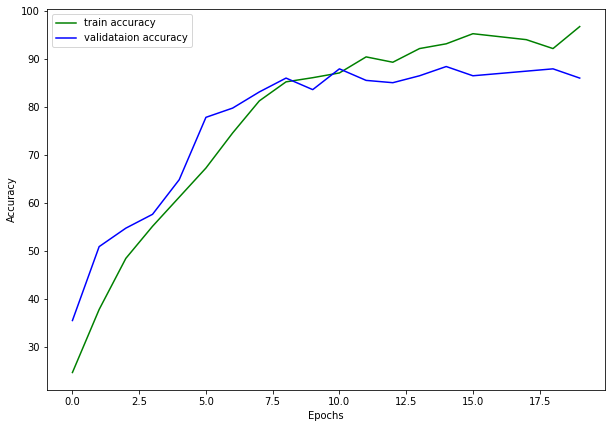

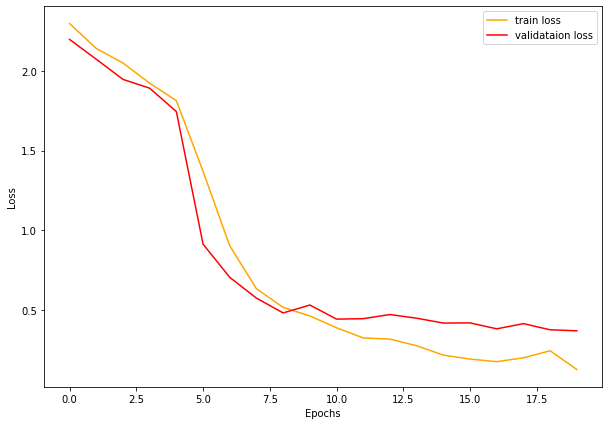

In [21]:
# hyper parameters
IMG_SIZE = (256, 256) # training resolution
NUM_CLASS = 11
EPOCHS = 20 # number of epochs we want to train
data_dir = "./data" # training data dir

Transform = T.Compose(
                    [T.ToTensor(),
                    T.Resize(IMG_SIZE),
                    T.RandomRotation(90),
                    T.RandomHorizontalFlip(p=0.5),
                    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

torch.cuda.empty_cache()

# create classifier instance
classifier = PollutionClassifier(data_dir=data_dir, num_classes=NUM_CLASS, device=device, sample=True, Transform=Transform)
# get train and val loader
train_loader, val_loader = classifier.load_data()
# load model in class
classifier.load_model()
# start training
logs_dict = classifier.fit(num_epochs=EPOCHS, unfreeze_after=5, train_loader=train_loader, val_loader=val_loader)

In [22]:
import pandas as pd

# write training result
result = pd.DataFrame.from_dict(logs_dict)
result.to_csv("./outputs/result.csv", index=False)

#### Inference

In [23]:
# need to change your test_image.zip dir
!unzip -q /content/drive/MyDrive/test_image.zip -d '/content/'

unzip:  cannot find or open /content/drive/MyDrive/test_image.zip, /content/drive/MyDrive/test_image.zip.zip or /content/drive/MyDrive/test_image.zip.ZIP.


In [24]:
# Inference
def load_model(model_path):
  model = torchvision.models.efficientnet_b0()

  in_features = model.classifier[1].in_features
  model.classifier[1] = nn.Linear(in_features=in_features, out_features=11)
  model = model.to(device)

  checkpoint = torch.load(model_path)
  model.load_state_dict(checkpoint)

  return model

model_path = './outputs/checkpoint.pt'
model = load_model(model_path)
model.eval();
# print(model)

In [25]:
# class dictionary
idx2class = {0: 'Bad Billboard',
 1: 'Bad Streetlight',
 2: 'Broken Signage',
 3: 'Clutter Sidewalk',
 4: 'Construction Road',
 5: 'Faded Signage',
 6: 'Garbage',
 7: 'Graffiti',
 8: 'Potholes',
 9: 'Sand On Road',
 10: 'Unkept Facade'}

In [26]:
Transform = T.Compose(
                    [T.ToTensor(),
                    T.Resize(IMG_SIZE),
                    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                    ])


def predict(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    orig_image = image.copy()

    image = Transform(image) 
    image = torch.unsqueeze(image, 0)
    image = image.to(device)

    # Forward pass throught the image.
    outputs = model(image)
    outputs = outputs.cpu().detach().numpy()
    # print(outputs)

    pred_class_name = idx2class[np.argmax(outputs[0])]

    return orig_image,  pred_class_name


def show_image(image, pred):
    plt.imshow(image)
    plt.title(pred)
    plt.axis('off')
    plt.show()
    

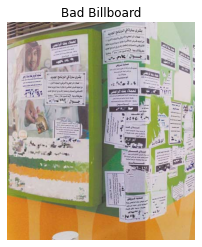

In [30]:
img_path = "drive/MyDrive/VisualPollution/test_image/310226_70328_bad_billboard.jpg"

image, pred = predict(img_path)
show_image(image, pred)

In [31]:
import glob

test_dir = "./test_image/"
for img in glob.glob(test_dir + "*"):
    image, pred = predict(img)
    # print(f"Pred: {pred.lower()} \n")
    show_image(image, pred)

In [32]:
# zip outputs folder
!zip -r /content/outputs.zip /content/outputs

  adding: content/outputs/ (stored 0%)
  adding: content/outputs/checkpoint.pt (deflated 8%)
  adding: content/outputs/accuracy.png (deflated 8%)
  adding: content/outputs/loss.png (deflated 7%)
  adding: content/outputs/result.csv (stored 0%)


In [33]:
#export your model's weights and outputs for future use
from google.colab import files
files.download('/content/outputs.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>